<a href="https://colab.research.google.com/github/tamtemtomm/kaggle-notebooks/blob/main/Algorithm_Artisans_Debut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algorithm Artisans
This is the notebook that I use to process the dataset from [DataQuest Objective Quest Competition - Elimination Round](https://www.kaggle.com/competitions/tahap-penyisihan-oq-dataquestua/leaderboard). I always use the collab version of this notebook, so sorry if there is some functionalities that don't work really well on jupyter. Go to this [link](https://colab.research.google.com/drive/1z6tasKc0ubuO8ZQodu-CBqz1vs6BtzHj#scrollTo=qWpvpBZQ1QPi) to open the colab version. Follow this guide if you have a problem running this notebook.

1. Kaggle.json <br>
Use your kaggle json to connect the colab into your kaggle account API. For more information about this, please go to this [link](https://www.kaggle.com/docs/api)

2. Checkpoint <br>
I use to a function to load and save a checkpoint. You can look into the function in [this](#scrollTo=x1AhGpXq4S2W)

3. Tranform Function <br>
I use markdown to simplify the process of choosing the transform function i wanna test. You can look it up in [this](#scrollTo=hkba4_FkEEx6)


That's all for me. Thank you for coming by!

##Import Datasets and Dependencies


In [ ]:
# @title <p> Install Dependencies
!pip install -q kaggle
!pip install jcopml >& /dev/null
!pip install catboost >& /dev/null
!pip install optuna >& /dev/null

In [ ]:
# @title <p>Essential Import
import os, shutil, json, time, datetime
from PIL import Image
from zipfile import ZipFile
import matplotlib.pyplot as plt
import numpy as np, pandas as pd, random as rd
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# @title <p>Sklearn Essential Import
import math
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, recall_score, precision_score, accuracy_score, f1_score, classification_report, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from xgboost import XGBClassifier, XGBRegressor
from jcopml.tuning.space import Integer, Real
import optuna

In [ ]:
# @title <p> Import kaggle API
from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# # @title <p>Import kaggle API from google drive
# from google.colab import drive
# drive.mount('/content/gdrive')

# ! mkdir ~/.kaggle
# ! cp '/content/gdrive/MyDrive/Colab Notebooks/kaggle.json' ~/.kaggle
# ! chmod 600 ~/.kaggle/kaggle.json

# drive.flush_and_unmount()

In [ ]:
# @title <p>Download Dataset
!kaggle competitions download -c tahap-penyisihan-oq-dataquestua
!unzip /content/tahap-penyisihan-oq-dataquestua.zip &> /dev/null
!rm /content/tahap-penyisihan-oq-dataquestua.zip

 68% 9.00M/13.2M [00:00<00:00, 16.4MB/s]
100% 13.2M/13.2M [00:00<00:00, 24.8MB/s]


## Data Description

Data description:
1. datetime : The time when the data was calculated (in UNIX timestamp format).
2. datetime_iso : Time in ISO 8601 format, including time zone.
3. time zone: Time zone in seconds against UTC.
4. temp: Current temperature in Celsius.
5. visibility: Average visibility in meters.
6. d_point : Current dew point in Celsius.
7. felt: The current felt temperature in Celsius.
8. min_temp : Minimum temperature in a certain time range in Celsius.
9. max_temp : Maximum temperature in a certain time range in Celsius.
10. pressure: Atmospheric pressure in hPa.
11. sea_level : Atmospheric pressure at sea level in hPa.
12. grnd_level : Atmospheric pressure at the ground surface in hPa.
13. hum: The percentage of humidity in the current air.
14. wind_spd : Current wind speed in m/s.
15. wind_deg : Wind direction in degrees.
16. rain_1h : Rainfall in the last 1 hour in mm. (variable target)
17. rain_3h : Rainfall in the last 3 hours in mm.
18. snow_1h : Snowfall in the last 1 hour in mm.
19. snow_3h : Snowfall in the last 3 hours in mm.
20. cloud : Current cloud cover percentage.

## Explore Datasets


The first stage is reading the train, test, and submission data using the Pandas library using the `read_csv` function. Next, it will display the top 5 data from each data using the `head()` function.

In [ ]:
train = pd.read_csv('/content/train.csv')
train.head()

,datetime,datetime_iso,time-zone,temp,visibility,d_point,feels,min_temp,max_temp,prssr,sea_level,grnd_level,hum,wind_spd,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds
0,283996800,1979-01-01 00:00:00+00:00,28800,24.75 Celcius,NaN,23.89 C,25.76 C,24.28,25.22°C,1012,undetermined,NaN,95,0.82,320.0 °,zero,0,NaN,NaN,100
1,284000400,1979-01-01 01:00:00+00:00,28800,24.58 C,NaN,23.73 C,25.57 C,23.99 C,25.26 C,1012,NaN,NaN,95,0.96 m/s,338.0°,0,0,0,0,100
2,284004000,1979-01-01 02:00:00+00:00,28800,26.6 Celcius,unidentified,24.06 C,26.6 C,26.1 C,27.39,1012,NaN,undetermined,86,1.22 m/s,339.0°,0,volume:zero,NaN,NaN,99
3,284007600,1979-01-01 03:00:00+00:00,28800,27.31 Celcius,NaN,24.37 C,30.9 C,26.59,28.36 C,1012,NaN,undetermined,84,1.08 m/s,342,0.13,nol,0,NaN,94
4,284011200,1979-01-01 04:00:00+00:00,28800,27.41,NaN,25.05 C,31.54 C,26.58 C,28.31 °C,1011,NaN,undetermined,87,0.86,336.0°,0.34,nol,NaN,0,100


In [ ]:
test = pd.read_csv('/content/test.csv')
test.head()

,datetime,datetime_iso,time-zone,temp,visibility,d_point,feels,min_temp,max_temp,prssr,sea_level,grnd_level,hum,wind_spd,wind_deg,rain_3h,snow_1h,snow_3h,clouds
0,1514764800,2018-01-01 00:00:00+00:00,28800,26.59 °C,NaN,23.66,26.59,26.02,27.16,1009,NaN,undetermined,84,1.45 m/s,355,0,NaN,no_snow,97
1,1514768400,2018-01-01 01:00:00+00:00,28800,26.51 C,NaN,24.92,26.51 °C,26.06,28.04,1009,NaN,undetermined,91,1.67 m/s,351,0mm,no-snow,0 milimeter,95
2,1514772000,2018-01-01 02:00:00+00:00,28800,28.68 C,NaN,25.71,34.68,28.03 C,29.3 C,1009.0 hPa.,NaN,NaN,84,1.72 m/s,345.0°,0 mm,volume:zero,0,90
3,1514775600,2018-01-01 03:00:00+00:00,28800,28.84 C,NaN,25.25,34.51,28.52,29.08 °C,1008,NaN,NaN,81,1.49,339.0°,0 milimeter,0,NaN,91
4,1514779200,2018-01-01 04:00:00+00:00,28800,29.75 Celcius,,24.62,35.38,29.31 C,30.57,1007,undetermined,undetermined,74,1.39 m/s,339.0°,NaN,0,volume:0,96


In [ ]:
sub = pd.read_csv('/content/sample_submission.csv')
sub.head()

,datetime_iso,rain_1h
0,2018-01-01 00:00:00+00:00,0
1,2018-01-01 01:00:00+00:00,0
2,2018-01-01 02:00:00+00:00,0
3,2018-01-01 03:00:00+00:00,0
4,2018-01-01 04:00:00+00:00,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341880 entries, 0 to 341879
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   datetime      341880 non-null  int64 
 1   datetime_iso  341880 non-null  object
 2   time-zone     341880 non-null  int64 
 3   temp          341880 non-null  object
 4   visibility    51112 non-null   object
 5   d_point       341880 non-null  object
 6   feels         341880 non-null  object
 7   min_temp      341880 non-null  object
 8   max_temp      341880 non-null  object
 9   prssr         341880 non-null  object
 10  sea_level     192964 non-null  object
 11  grnd_level    192919 non-null  object
 12  hum           341880 non-null  object
 13  wind_spd      341880 non-null  object
 14  wind_deg      341880 non-null  object
 15  rain_1h       341880 non-null  object
 16  rain_3h       192329 non-null  object
 17  snow_1h       192696 non-null  object
 18  snow_3h       192699 non

In [ ]:
train.describe()

,datetime,time-zone
count,3.418800e+05,341880.0
mean,8.993790e+08,28800.0
std,3.552926e+08,0.0
min,2.839968e+08,28800.0
25%,5.916879e+08,28800.0
50%,8.993790e+08,28800.0
75%,1.207070e+09,28800.0
max,1.514761e+09,28800.0


## Load Checkpoint

In [ ]:
# @title <p> Make a Load Checkpoint Function
def load_config(load=True):
  os.makedirs('checkpoint', exist_ok=True)

  from google.colab import files
  cp = files.upload()

  cpname = list(cp.keys())
  cppath = os.path.join('checkpoint', cpname[-1])
  shutil.move(cpname[-1], cppath)

  os.makedirs(os.path.join('checkpoint', cpname[-1].split('.')[0]), exist_ok=True)
  with ZipFile(cppath, 'r') as zip_ref:
      zip_ref.extractall(os.path.join('checkpoint', cpname[-1].split('.')[0]))

  os.remove(os.path.join('checkpoint', cpname[-1]))

  if load:
    train_transformed = pd.read_csv(os.path.join('checkpoint', cpname[-1].split('.')[0], 'train_Algorithm Artisans.csv'))
    test_transformed = pd.read_csv(os.path.join('checkpoint', cpname[-1].split('.')[0], 'test_Algorithm Artisans.csv'))
    sub = pd.read_csv(os.path.join('checkpoint', cpname[-1].split('.')[0], 'submission.csv'))

    with open(os.path.join('checkpoint', cpname[-1].split('.')[0], 'model_Algorithm Artisans.pkl'), 'rb') as model_file:
        model = pickle.load(model_file)

In [ ]:
# @title <p> Make Save Config Function
def save_config(submit=False, zip=False, download=False):
  if download : zip = True
  os.makedirs('submission', exist_ok=True)
  current_datetime = str(datetime.datetime.now())
  if submit:
    current_datetime = 'SUB_' + current_datetime

  os.makedirs(os.path.join('submission', current_datetime), exist_ok=True)

  train_transformed.to_csv(os.path.join('submission', current_datetime, 'train_Algorithm Artisans.csv'), index=False)
  test_transformed.to_csv(os.path.join('submission', current_datetime, 'test_Algorithm Artisans.csv'), index=False)
  with open(os.path.join('submission', current_datetime, 'model_Algorithm Artisans.pkl'), 'wb') as model_file:
    pickle.dump(pipeline, model_file)

  if submit:
    sub.to_csv(os.path.join('submission', current_datetime, 'submission.csv'), index=False)

  if zip :
    path = os.path.join('submission', current_datetime)
    shutil.make_archive(path, 'zip', path)

  if download:
    from google.colab import files
    files.download(path + '.zip')

In [ ]:
# load_config()

## Preprocessing

Next, in the data preprocessing stage, this code includes several key steps to prepare the dataset before being used in model training and testing. The steps performed in this code are as follows:

1. **Date Format Processing**: The code converts the 'datetime_iso' column into datetime format to allow better time analysis.

2. **Categorical Column Processing**: Several categorical columns such as 'visibility', 'sea_level', 'grnd_level', 'rain_3h', 'snow_1h', and 'snow_3h' are converted into binary features by one-hot encoding technique using ` pd.get_dummies`.

3. **Numeric Column Processing**: Numerical columns such as 'temp', 'd_point', 'feels', etc., through the `transform_feature` function, are processed to remove additional units or characters and change the data type to float.

4. **Data Normalization**: There are three types of normalization to choose from: quartile, extreme, or custom. Quartile and extreme normalization is carried out by removing outliers using the `count_top_bottom` function and ensuring the values ​​are within certain limits. Custom normalization is performed by setting specific constraints for each numeric column.

5. **Derivative Data Processing**: Differential data (changes in numeric columns over time) can be generated by selecting options such as 'diff', 'diff_2', 'diff_after', 'diff_2_after', and 'diff_between'. This can help the model in capturing trends or patterns in the data.

6. **Time Data Processing**: Time data is broken down into time related features such as 'hour', 'time_of_day', 'date', 'day_of_week', 'is_weekend', 'month', 'season', 'year ', and 'decade'. These features allow the model to understand seasonal patterns, daily changes, and trends over time.

7. **Additional Data Processing**: Several additional features such as 'visibility_1' and 'visibility_1000' are also created based on existing data.

8. **Sine and Cosine of the Clock**: In the 'hour' feature, the sine and cosine of the clock are used to encode time information in a form that is more suitable for the model.

9. **Feature Interaction**: If selected, interaction features such as 'day_hour_interaction' and 'day_hour_combined' are calculated based on a combination of time and day.

10. **Hourly and Daily Averages**: If selected, hourly and daily averages for numeric features are also calculated.

11. **Data Check**: Finally, the code checks whether there are empty or duplicate values ​​in the dataset after all the transformations have been performed.


In [ ]:
# @title <p> Make Feature Transform Function
def transform_feature(x, rain_1h=False):
  if not rain_1h :
    return float(str(x).split()[0].split('°')[0].strip('%').strip('m/s').strip('hPa'))
  else :
    if x not in ['nol', 'volume:zero', 'volume:0', 'zero', 'no-snow', 'no_snow', 'no-rain', 'no_rain', ' ', ''] :
      x = float(str(x).split()[0].strip('mm'))
      x = x if x >= 0 else 0
      return x
    else : return 0

def count_top_bottom(df, column, mult=3):
  IQR = df[column].quantile(0.75) - df[column].quantile(0.25)
  Lower_fence = df[column].quantile(0.25) - (IQR * mult)
  Upper_fence = df[column].quantile(0.75) + (IQR * mult)
  return Lower_fence, Upper_fence


In [ ]:
# @title <p> Make Transform Function : Extensive Feature Engineering

#@markdown <font color="#CC3E3E">**Main Features**</font>
hour = True #@param {type:"boolean"}
time_of_day = True #@param {type:"boolean"}
day = True #@param {type:"boolean"}
day_of_week = True #@param {type:"boolean"}
weekend = False #@param {type:"boolean"}
month = True #@param {type:"boolean"}
season = True #@param {type:"boolean"}
year  = True #@param {type:"boolean"}
decade = False #@param {type:"boolean"}
visibility = True #@param {type:"boolean"}
sea = True #@param {type:"boolean"}
ground = True #@param {type:"boolean"}
rain_3h = False #@param {type:"boolean"}
snow_1h = False #@param {type:"boolean"}
snow_3h = False #@param {type:"boolean"}

#@markdown <font color="#CC3E3E">**Transforms**</font>
sebelum_beberapa_jam = True #@param {type:"boolean"}
setelah_beberapa_jam = True #@param {type:"boolean"}
selisih_1_jam = True #@param {type:"boolean"}
selisih_2_jam = True #@param {type:"boolean"}
selisih_3_jam = False #@param {type:"boolean"}
selisih_1_jam_setelah = True #@param {type:"boolean"}
selisih_2_jam_setelah = True #@param {type:"boolean"}
selisih_3_jam_setelah = False #@param {type:"boolean"}
selisih_depan_belakang = True #@param {type:"boolean"}
rataan_per_jam = False #@param {type:"boolean"}
rataan_per_hari = True #@param {type:"boolean"}
rataan_per_bulan = False #@param {type:"boolean"}
sincos = True #@param {type:"boolean"}
interaksi = True #@param {type:"boolean"}
rolling_mean  = True #@param {type:"boolean"}
range_suhu = True #@param {type:"boolean"}
range_suhu2 = True #@param {type:"boolean"}
kuadrat_suhu = True #@param {type:"boolean"}
laju_evaporasi = True #@param {type:"boolean"}
perubahan_tekanan_3h = True #@param {type:"boolean"}
index_panas = True #@param {type:"boolean"}
ketidaknyamanan = False #@param {type:"boolean"}
aliran_angin_vertikal = False #@param {type:"boolean"}


def transform_df(df:pd.DataFrame,
                 scale='quartil',
                 visibility=visibility,
                 sea=sea,
                 ground=ground,
                 rain_3h=rain_3h,
                 snow_1h=snow_1h,
                 snow_3h=snow_3h,
                 hour=hour,
                 tod=time_of_day,
                 day=day,
                 dow=day_of_week,
                 weekend=weekend,
                 month=month,
                 season=season,
                 year=year,
                 decade=decade,
                 lag=sebelum_beberapa_jam,
                 lead=setelah_beberapa_jam,
                 diff=selisih_1_jam,
                 diff_2=selisih_2_jam,
                 diff_3=selisih_3_jam,
                 diff_after=selisih_1_jam_setelah,
                 diff_2_after=selisih_2_jam_setelah,
                 diff_3_after=selisih_3_jam_setelah,
                 diff_between=selisih_depan_belakang,
                 hour_mean=rataan_per_jam,
                 day_mean=rataan_per_hari,
                 month_mean=rataan_per_bulan,
                 sincos=sincos,
                 interaction=interaksi,
                 rolling_mean=rolling_mean,
                 temp_range=range_suhu,
                 temp_feels_range=range_suhu2,
                 temp_squared=kuadrat_suhu,
                 evaporation_rate= laju_evaporasi,
                 prrsr_change_3h= perubahan_tekanan_3h,
                 heat=index_panas,
                 discomfort=ketidaknyamanan,
                 vertical_air_flow=aliran_angin_vertikal,
                 ):

  df = df.copy()

# FEATURE ENGINEERING 1
#--------------------------------------------------------------------------------------------------------------
  df['datetime_iso'] = pd.to_datetime(df['datetime_iso'])

  if visibility:
    df['visibility_1'] = df['visibility'].apply(lambda x : 1 if x in ['-1m', '-1', '-1 m'] else 0)
    df['visibility_1000'] = df['visibility'].apply(lambda x : 1 if x in ['-1km', '-1 km'] else 0)

  if sea:
    df = df.join(pd.get_dummies(df['sea_level'], prefix='sea_'))

  if ground :
    df = df.join(pd.get_dummies(df['grnd_level'], prefix='grnd_'))

  if rain_3h :
    df = df.join(pd.get_dummies(df['rain_3h'], prefix='rain_3h_'))

  if snow_1h :
    df = df.join(pd.get_dummies(df['snow_1h'], prefix='snow_1h_'))

  if snow_3h :
    df = df.join(pd.get_dummies(df['snow_3h'], prefix='snow_3h_'))

  df.drop(['datetime', 'time-zone', 'visibility', 'grnd_level', 'sea_level', 'datetime', 'rain_3h', 'snow_1h', 'snow_3h'], axis=1, inplace=True)
  for column in df.columns:
    if column not in ['datetime_iso', 'rain_1h', 'visibility_1', 'visibility_1000']:
      df[column] = df[column].apply(lambda x : transform_feature(x))
    elif column == 'rain_1h' :
       df[column] = df[column].apply(lambda x : transform_feature(x, rain_1h=True))


# SCALING MAIN FEATURES
#-------------------------------------------------------------------------------------------------------------

  if scale=='quartil':
    for column in ['temp', 'd_point', 'feels', 'min_temp', 'max_temp', 'prssr', 'wind_deg', 'wind_spd', 'hum']:
      bottom, top = count_top_bottom(df, column)
      df[column] = df[column].apply(lambda x : x if x <= top else top)
      df[column] = df[column].apply(lambda x : x if x >= bottom else bottom)

    df['hum'] = df['hum'].apply(lambda x : x if x<=100 else 100)
    df['temp'] = df['temp'].apply(lambda x : x if x>=17.5 else 22.5)
    df['temp'] = df['temp'].apply(lambda x : x if x<35 else 25)

    med = df['feels'].median()
    df['feels'] = df['feels'].apply(lambda x : x if x>=5 else med)
    df['feels'] = df['feels'].apply(lambda x : x if x<40 else med)

    med = df['max_temp'].median()
    df['max_temp'] = df['max_temp'].apply(lambda x : x if x<=35 else med)
    df['max_temp'] = df['max_temp'].apply(lambda x : x if x>=20 else 25)

    med = df['min_temp'].median()
    df['min_temp'] = df['min_temp'].apply(lambda x : x if x<=35 else med)

    med = df['d_point'].median()
    df['d_point'] = df['d_point'].apply(lambda x : x if x<=28 else med)
    df['wind_spd'] = df['wind_spd'].apply(lambda x : x if x<=3 else 1)
    df['wind_deg'] = df['wind_deg'].apply(lambda x : x if x<=400 else 200)

    bottom, top = count_top_bottom(df, 'clouds')
    df['clouds'] = df['clouds'].apply(lambda x : bottom if x<bottom else x)

    df['min_temp'] = df['min_temp'].apply(lambda x : 20 if x<20 else x )

    df['clouds'] = df['clouds'].apply(lambda x : np.log(x))


  if scale=='extreme':
    for column in ['temp', 'd_point', 'feels', 'min_temp', 'max_temp', 'prssr', 'wind_deg', 'wind_spd', 'hum', 'clouds']:
      bottom, top = count_top_bottom(df, column)
      df[column] = df[column].apply(lambda x : x if x <= top else top)
      df[column] = df[column].apply(lambda x : x if x >= bottom else bottom)
    for column in ['temp', 'd_point', 'feels', 'min_temp', 'max_temp', 'prssr', 'wind_deg', 'wind_spd', 'hum', 'clouds']:
      bottom, top = df[column].quantile(0.25), df[column].quantile(0.75)
      df[column] = df[column].apply(lambda x : x if x <= top else top)
      df[column] = df[column].apply(lambda x : x if x >= bottom else bottom)

  if scale=='costum':
    df['temp'] = df['temp'].apply(lambda x : x if (x < 100 and x >= 0) else df['temp'].median())
    df['d_point'] = df['d_point'].apply(lambda x : x if (x < 80 and x >= 0) else df['d_point'].median())
    df['feels'] = df['feels'].apply(lambda x : x if (x < 100 and x >= 0) else df['feels'].median())
    df['min_temp'] = df['min_temp'].apply(lambda x : x if (x < 100 and x >= 0) else df['min_temp'].median())
    df['max_temp'] = df['max_temp'].apply(lambda x : x if (x < 100 and x >= 0) else df['max_temp'].median())
    df['prssr'] = df['prssr'].apply(lambda x : x if (x < 1500 and x >= 0) else 1010)
    df['wind_deg'] = df['wind_deg'].apply(lambda x : x % 360 )

    bottom, top = count_top_bottom(df, 'wind_spd')
    df['wind_spd'] = df['wind_spd'].apply(lambda x : x if x <= top else top)

    bottom, top = count_top_bottom(df, 'hum')
    df['hum'] = df['hum'].apply(lambda x : x if (x <= top and x<=100) else 100)
    df['hum'] = df['hum'].apply(lambda x : x if (x >= bottom and x>=0) else bottom)

    bottom, top = count_top_bottom(df, 'd_point')
    df['d_point'] = df['d_point'].apply(lambda x : x if (x <= top and x<=100) else 100)
    df['d_point'] = df['d_point'].apply(lambda x : x if (x >= bottom and x>=0) else bottom)
    df['d_point'] = df['d_point'].apply(lambda x : x if x <= 40 else df['d_point'].median())


# FEATURE ENGINEERING 2
#-------------------------------------------------------------------------------------------------------------

  if hour:
    df['hour'] = df['datetime_iso'].dt.hour.apply(lambda x: x/23)

  if sincos:
    df['hour_sin'] = np.sin(df['hour'] * 24 * (2 * np.pi / 24))
    df['hour_cos'] = np.cos(df['hour'] * 24 * (2 * np.pi / 24))

  if tod:
    df['time_of_day'] = df['datetime_iso'].dt.hour.apply(lambda x: 1 if 6 <= x < 12 else 2 if 12 <= x < 18 else 3 if 18 <= x < 24 else 4)
    df['time_of_day'] = df['time_of_day'].apply(lambda x : x/4)

  if day:
    df['date'] = df['datetime_iso'].dt.day.apply(lambda x: x/31)

  if dow:
    df['day_of_week'] = df['datetime_iso'].dt.dayofweek.apply(lambda x : x/6)

  if weekend:
    df['is_weekend'] = df['datetime_iso'].dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)

  if month :
    df['month'] = df['datetime_iso'].dt.month.apply(lambda x: x/12)

  if season :
    df['season'] = df['datetime_iso'].dt.month.apply(lambda x: 1 if x in [12, 1, 2] else 2 if x in [3, 4, 5] else 3 if x in [6, 7, 8] else 4)

  if year:
    df['year'] = df['datetime_iso'].dt.year.apply(lambda x: x/2017)

  if decade:
    df['decade'] = df['datetime_iso'].dt.year.apply(lambda x: x/10)


# FEATURE ENGINEERING 3
#-------------------------------------------------------------------------------------------------------------

  if diff:
    for column in ['temp', 'd_point', 'feels', 'min_temp', 'max_temp', 'prssr', 'wind_deg', 'wind_spd', 'hum', 'clouds'] :
      df = df.join(df[column].diff(), rsuffix='_diff')
      df[column + '_diff'][0] = 0

  if diff_2:
    for column in ['temp', 'd_point', 'feels', 'min_temp', 'max_temp', 'prssr', 'wind_deg', 'wind_spd', 'hum', 'clouds'] :
      df = df.join(df[column].diff(2), rsuffix='_diff_2')
      df[column + '_diff_2'][0] = 0
      df[column + '_diff_2'][1] = 0

  if diff_after:
    for column in ['temp', 'd_point', 'feels', 'min_temp', 'max_temp', 'prssr', 'wind_deg', 'wind_spd', 'hum', 'clouds'] :
      df[column + '_diff_after'] = df[column + '_diff'].shift(-1).apply(lambda x : -(x))
      df[column + '_diff_after'][len(df)-1] = 0

  if diff_2_after:
    for column in ['temp', 'd_point', 'feels', 'min_temp', 'max_temp', 'prssr', 'wind_deg', 'wind_spd', 'hum', 'clouds'] :
      df[column + '_diff_2_after'] = df[column + '_diff_2'].shift(-1).apply(lambda x : -(x))
      df[column + '_diff_2_after'][len(df)-1] = 0
      df[column + '_diff_2_after'][len(df)-2] = 0

  if diff_3:
    for column in ['temp', 'd_point', 'feels', 'min_temp', 'max_temp', 'prssr', 'wind_deg', 'wind_spd', 'hum', 'clouds'] :
      df = df.join(df[column].diff(3), rsuffix='_diff_3')
      df[column + '_diff_2'][0] = 0
      df[column + '_diff_2'][1] = 0
      df[column + '_diff_2'][2] = 0

  if diff_3_after:
    for column in ['temp', 'd_point', 'feels', 'min_temp', 'max_temp', 'prssr', 'wind_deg', 'wind_spd', 'hum', 'clouds'] :
      df[column + '_diff_3_after'] = df[column + '_diff_3'].shift(-1).apply(lambda x : -(x))
      df[column + '_diff_3_after'][len(df)-1] = 0
      df[column + '_diff_3_after'][len(df)-2] = 0
      df[column + '_diff_3_after'][len(df)-3] = 0

  if diff_between:
    for column in ['temp', 'd_point', 'feels', 'min_temp', 'max_temp', 'prssr', 'wind_deg', 'wind_spd', 'hum', 'clouds'] :
      df = df.join(df[column].diff(2), rsuffix='_diff_between')
      df[column + '_diff_between'][0] = 0
      df[column + '_diff_between'][1] = 0

      df[column + '_diff_between'] = df[column + '_diff_between'].shift(-1)
      df[column + '_diff_between'][len(df)-1] = 0

  if lag:
    lag_features = ['hour_sin', 'd_point', 'feels', 'temp', 'hum']
    lag_hours = [1, 2, 3]

    for feature in lag_features:
        for lag in lag_hours:
            df[f'{feature}_lag{lag}'] = df[feature].shift(periods=lag)
  if lead:
    lead_features = ['hour_sin', 'd_point', 'feels', 'temp', 'hum']
    lead_hours = [-1, -2, -3]

    for feature in lead_features:
        for lead in lead_hours:
            df[f'{feature}_lead{lead}'] = df[feature].shift(periods=lead)

  if hour_mean:
    for column in ['temp', 'd_point', 'feels', 'min_temp', 'max_temp', 'prssr', 'wind_deg', 'wind_spd', 'hum', 'clouds'] :
      mean_by_day = df.groupby('hour')[column].mean().reset_index()
      mean_by_day.columns = ['hour', column + '_hour_mean']

      df = df.merge(mean_by_day, on='hour', how='left')

  if day_mean:
    for column in ['temp', 'd_point', 'feels', 'min_temp', 'max_temp', 'prssr', 'wind_deg', 'wind_spd', 'hum', 'clouds'] :
      mean_by_day = df.groupby(['date', 'month', 'year'])[column].mean().reset_index()
      mean_by_day.columns = ['date', 'month', 'year', column + '_day_mean']

      df = df.merge(mean_by_day, on=['date', 'month', 'year'], how='left')

  if month_mean:
    for column in ['temp', 'd_point', 'feels', 'min_temp', 'max_temp', 'prssr', 'wind_deg', 'wind_spd', 'hum', 'clouds'] :
      mean_by_day = df.groupby(['month', 'year'])[column].mean().reset_index()
      mean_by_day.columns = ['month', 'year', column + '_day_mean']

      df = df.merge(mean_by_day, on=['month', 'year'], how='left')

# FEATURE ENGINEERING 4
#-------------------------------------------------------------------------------------------------------------

  if temp_range:
    df['temp_range'] = df['max_temp'] - df['min_temp']

  if temp_feels_range:
    df['temp_feels_range'] = (df['max_temp']*df['feels']) - (df['min_temp']*df['feels'])

  if temp_squared:
    df['temp_squared'] = df['temp'] ** 2

  if evaporation_rate:
    df['evaporation_rate'] = df['temp'] - df['d_point']

  if prrsr_change_3h:
    df['prssr_change_3h'] = df['prssr'].diff(periods=3)

  if vertical_air_flow:
    df['vertical_air_flow'] = df['wind_spd'] * df['prssr'].diff()

  if heat:
    df['heat_index'] = df['temp'] + (0.36 * df['d_point']) + (0.49 * df['temp']) - (0.14 * df['d_point']) - 40

  if discomfort:
    df['discomfort_index'] = 0.5 * (df['temp'] + 61.0 + ((df['temp'] - 68.0) * 1.2) + (df['hum'] * 0.094))

  if rolling_mean:
    df['hum_rolling_mean'] = df['hum'].rolling(window=3).mean().fillna(0)

  if interaction:
    df['day_hour_interaction'] = df['day_of_week'] * (df['hour']*24)
    df['day_hour_combined'] = df['day_of_week'] * 24 + (df['hour']*24)
    df['wind_interaction'] = df['wind_spd'] * df['wind_deg']
    df['temp_hum_interaction'] = df['temp'] * df['hum']

  df.fillna(method='ffill', inplace=True)
  df.fillna(method='bfill', inplace=True)

  return df

In this code, train and test data are executed through the `transform_df` function, which performs a number of transformations on the dataset according to the given parameters. After the transformation is complete, an examination of the transformed dataset is carried out.


In [ ]:
# @title <p> Transform data

train_transformed = transform_df(train)
test_transformed = transform_df(test)

print(f"Data Kosong : {train_transformed.isna().any().any()}")
print(f"Data Duplikat : {train_transformed.duplicated().any().any()}")

Data Kosong : False
Data Duplikat : False


The `train_transformed.isna().any().any()` command is used to check whether there is empty data (missing values) in the transformed dataset. Meanwhile `train_transformed.duplicated().any().any()` is used to check whether there are duplicate data in the transformed dataset. The results of these two statements will print information about whether there is empty and/or duplicate data in the transformed dataset.

In [ ]:
train_transformed.head()

,datetime_iso,temp,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,...,temp_feels_range,temp_squared,evaporation_rate,prssr_change_3h,heat_index,hum_rolling_mean,day_hour_interaction,day_hour_combined,wind_interaction,temp_hum_interaction
0,1979-01-01 00:00:00+00:00,24.75,23.89,25.76,24.28,25.22,1012.0,95.0,0.82,320.0,...,24.2144,612.5625,0.86,0.0,2.1333,0.000000,0.0,0.000000,262.40,2351.25
1,1979-01-01 01:00:00+00:00,24.58,23.73,25.57,23.99,25.26,1012.0,95.0,0.96,338.0,...,32.4739,604.1764,0.85,0.0,1.8448,0.000000,0.0,1.043478,324.48,2335.10
2,1979-01-01 02:00:00+00:00,26.60,24.06,26.60,26.10,27.39,1012.0,86.0,1.22,339.0,...,34.3140,707.5600,2.54,0.0,4.9272,92.000000,0.0,2.086957,413.58,2287.60
3,1979-01-01 03:00:00+00:00,27.31,24.37,30.90,26.59,28.36,1012.0,84.0,1.08,342.0,...,54.6930,745.8361,2.94,0.0,6.0533,88.333333,0.0,3.130435,369.36,2294.04
4,1979-01-01 04:00:00+00:00,27.41,25.05,31.54,26.58,28.31,1011.0,87.0,0.86,336.0,...,54.5642,751.3081,2.36,-1.0,6.3519,85.666667,0.0,4.173913,288.96,2384.67


## Data Visualization
Create functions for distribution visualization and detect outliers in key features of the data

In [ ]:
# @title <p> Make Plot Disribution Function (Histplot)
def plot_dist2(df:pd.DataFrame):
  plt.rcParams["figure.figsize"] = [20, 20]
  sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
  fig, axes = plt.subplots(5,2)

  a = sns.histplot(df['temp'],  ax=axes[0,0])
  a.set_xlabel(xlabel = 'Temp Distribution', fontsize = 12, fontweight='bold', color='#333333')

  b = sns.histplot(df['d_point'], ax=axes[0,1])
  b.set_xlabel(xlabel = 'D_point Distribution', fontsize = 12, fontweight='bold', color='#333333')

  c = sns.histplot(df['feels'], ax=axes[1,0])
  c.set_xlabel(xlabel = 'Feels Distribution', fontsize = 12, fontweight='bold', color='#333333')

  d = sns.histplot(df['min_temp'], ax=axes[1,1])
  d.set_xlabel(xlabel = 'Min Temp Distribution', fontsize = 12, fontweight='bold', color='#333333')

  e = sns.histplot(df['max_temp'], ax=axes[2,0])
  e.set_xlabel(xlabel = 'Max Temp Distribution', fontsize = 12, fontweight='bold', color='#333333')

  f = sns.histplot(df['prssr'], ax=axes[2,1])
  f.set_xlabel(xlabel = 'Pressure Distribution', fontsize = 12, fontweight='bold', color='#333333')

  g = sns.histplot(df['hum'], ax=axes[3,0])
  g.set_xlabel(xlabel = 'Humidity Pressure Distribution', fontsize = 12, fontweight='bold', color='#333333')

  h = sns.histplot(df['wind_spd'], ax=axes[3,1])
  h.set_xlabel(xlabel = 'Wind Speed Distribution', fontsize = 12, fontweight='bold', color='#333333')

  h = sns.histplot(df['wind_deg'], ax=axes[4,0])
  h.set_xlabel(xlabel = 'Wind Degree Consuming Distribution', fontsize = 12, fontweight='bold', color='#333333')

  i = sns.histplot(df['clouds'], ax=axes[4,1])
  i.set_xlabel(xlabel = 'Clouds Distribution', fontsize = 12, fontweight='bold', color='#333333')

  fig.suptitle("Feature Distribution", fontsize=20, fontweight='bold', color='#333333')
  plt.tight_layout()
  plt.show()

In [ ]:
# @title <p> Make Plot Disribution Function (Boxplot)
def plot_dist(df:pd.DataFrame):
  plt.rcParams["figure.figsize"] = [20, 20]
  sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
  fig, axes = plt.subplots(5,2)

  a = sns.boxplot(df['temp'], orient='h',  ax=axes[0,0])
  a.set_xlabel(xlabel = 'Temp Distribution', fontsize = 12, fontweight='bold', color='#333333')

  b = sns.boxplot(df['d_point'], orient='h', ax=axes[0,1])
  b.set_xlabel(xlabel = 'D_point Distribution', fontsize = 12, fontweight='bold', color='#333333')

  c = sns.boxplot(df['feels'], orient='h', ax=axes[1,0])
  c.set_xlabel(xlabel = 'Feels Distribution', fontsize = 12, fontweight='bold', color='#333333')

  d = sns.boxplot(df['min_temp'], orient='h', ax=axes[1,1])
  d.set_xlabel(xlabel = 'Min Temp Distribution', fontsize = 12, fontweight='bold', color='#333333')

  e = sns.boxplot(df['max_temp'], orient='h', ax=axes[2,0])
  e.set_xlabel(xlabel = 'Max Temp Distribution', fontsize = 12, fontweight='bold', color='#333333')

  f = sns.boxplot(df['prssr'], orient='h', ax=axes[2,1])
  f.set_xlabel(xlabel = 'Pressure Distribution', fontsize = 12, fontweight='bold', color='#333333')

  g = sns.boxplot(df['hum'], orient='h', ax=axes[3,0])
  g.set_xlabel(xlabel = 'Humidity Pressure Distribution', fontsize = 12, fontweight='bold', color='#333333')

  h = sns.boxplot(df['wind_spd'], orient='h', ax=axes[3,1])
  h.set_xlabel(xlabel = 'Wind Speed Distribution', fontsize = 12, fontweight='bold', color='#333333')

  h = sns.boxplot(df['wind_deg'], orient='h', ax=axes[4,0])
  h.set_xlabel(xlabel = 'Wind Degree Consuming Distribution', fontsize = 12, fontweight='bold', color='#333333')

  i = sns.boxplot(df['clouds'], orient='h', ax=axes[4,1])
  i.set_xlabel(xlabel = 'Clouds Distribution', fontsize = 12, fontweight='bold', color='#333333')

  fig.suptitle("Feature Distribution", fontsize=20, fontweight='bold', color='#333333')
  plt.tight_layout()
  plt.show()

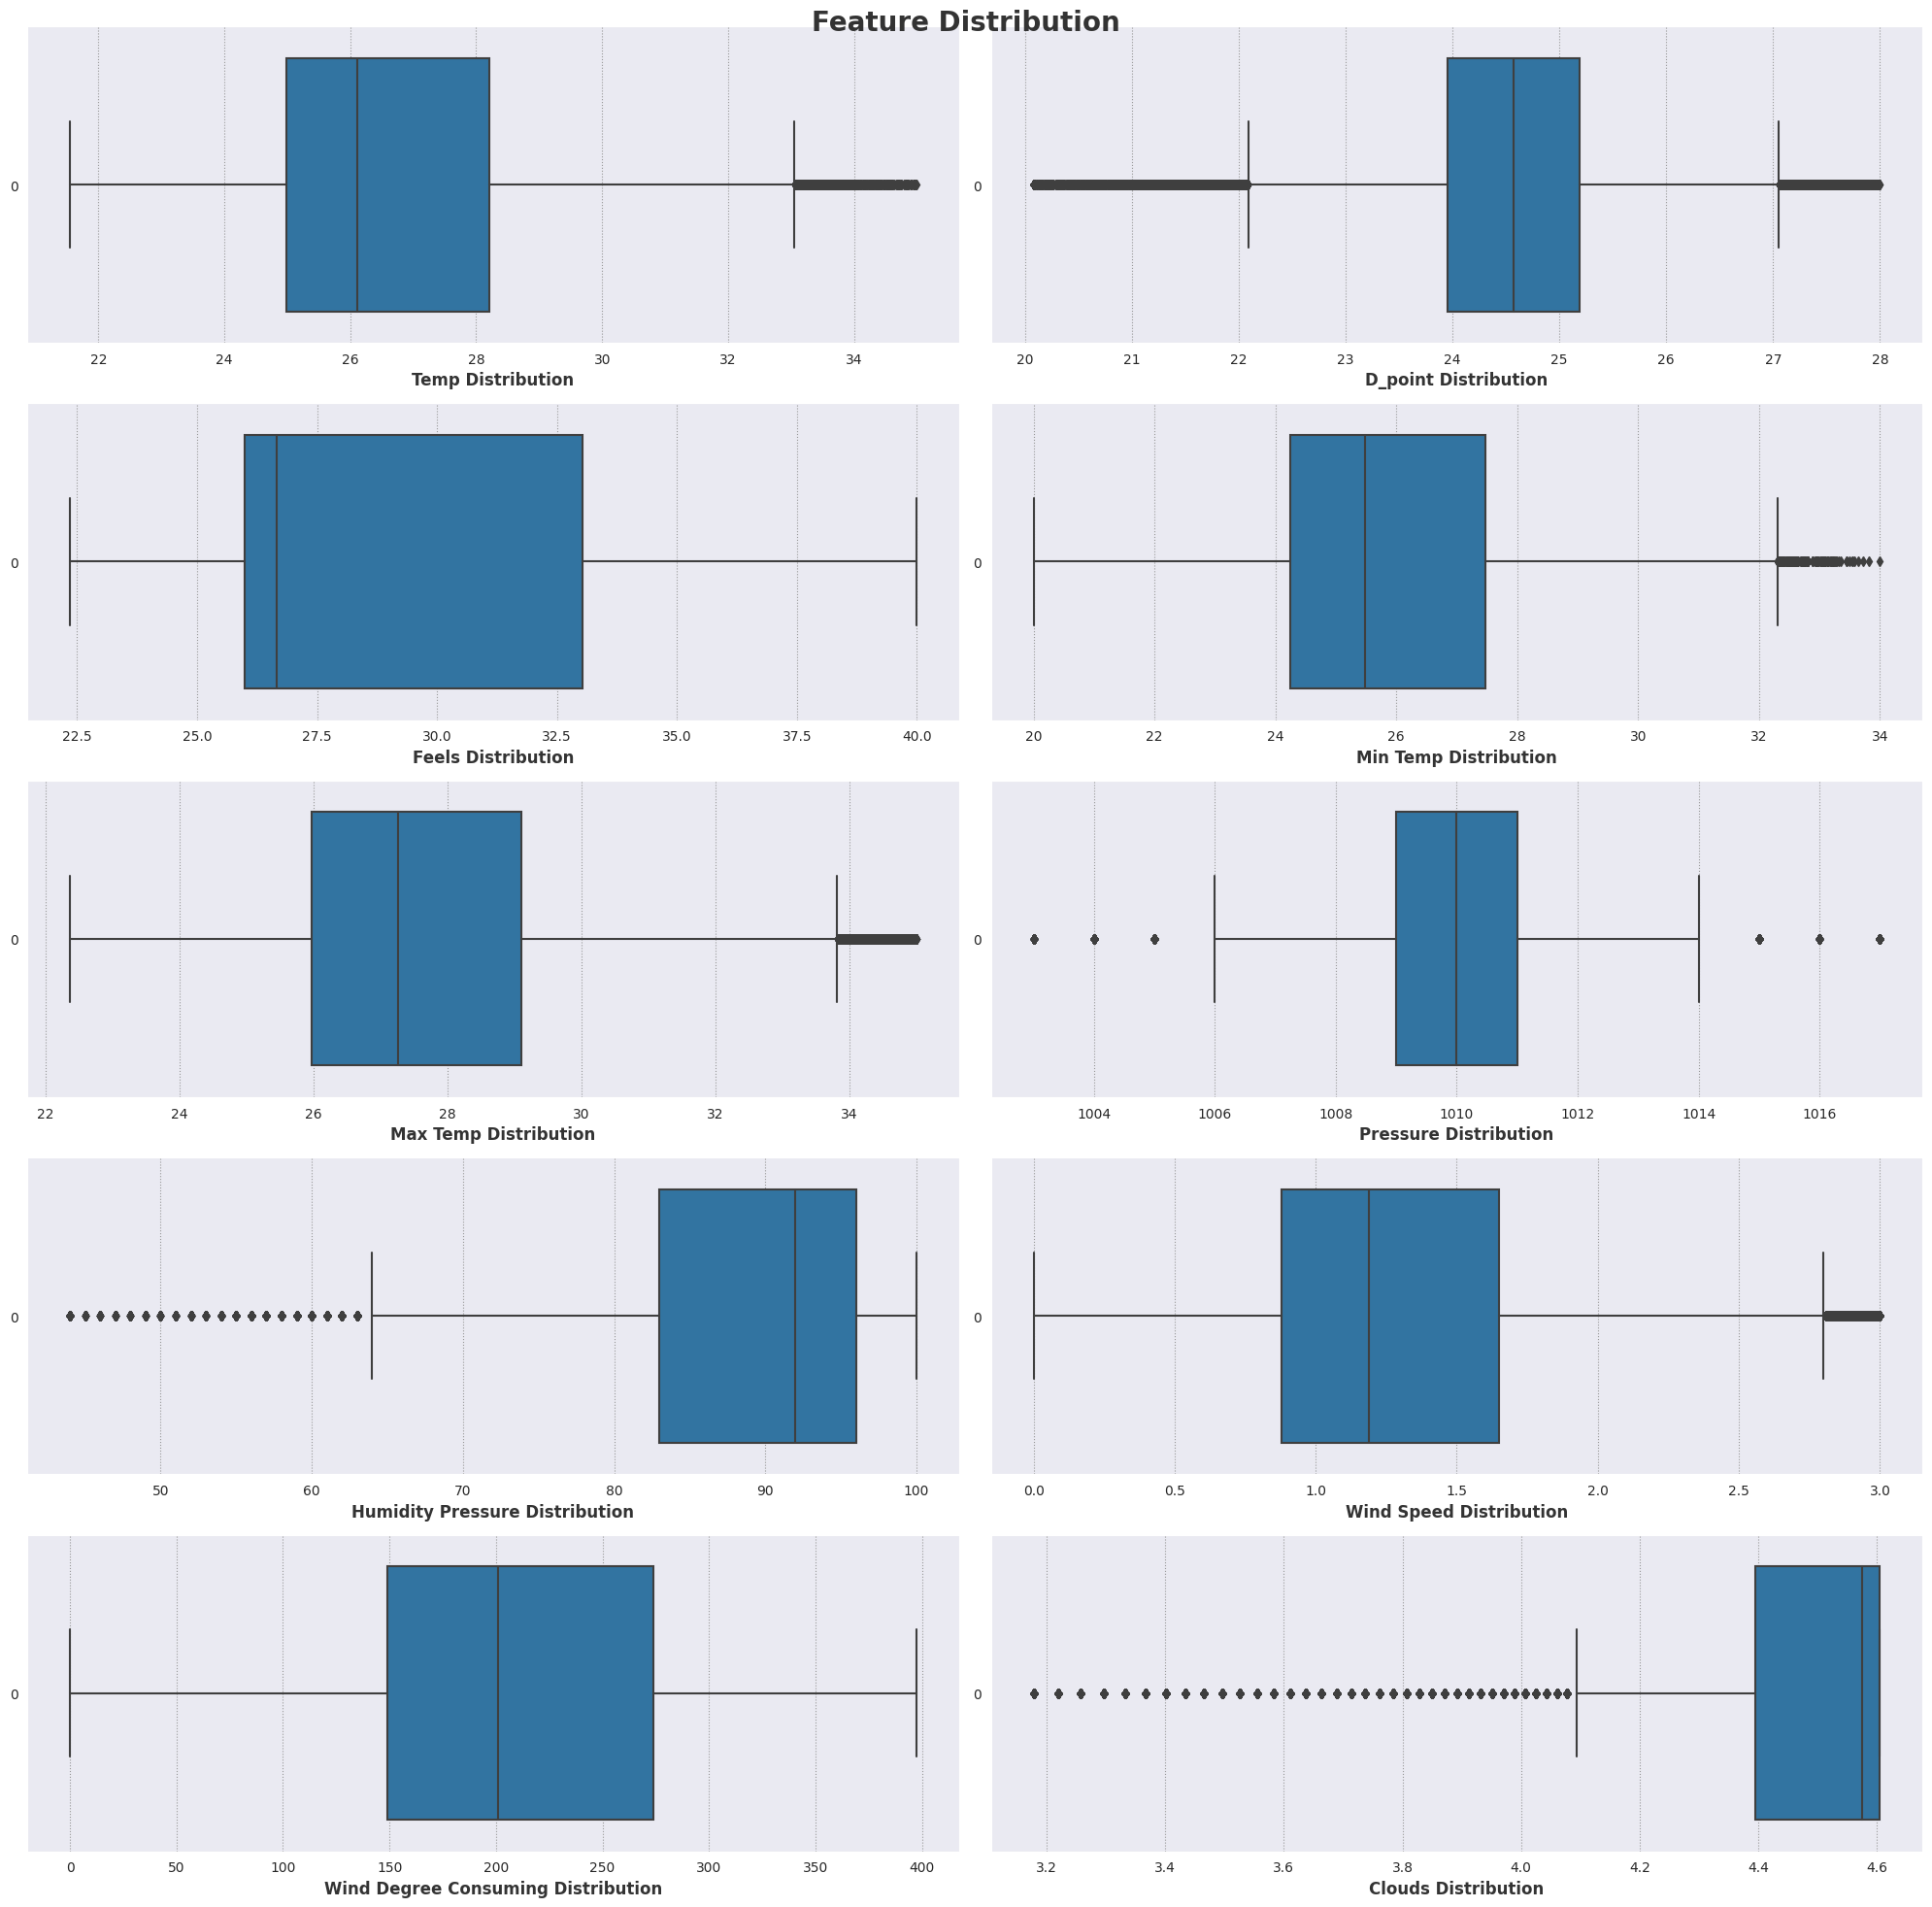

In [ ]:
# @title <p> Visualize Distribution
plot_dist(train_transformed)

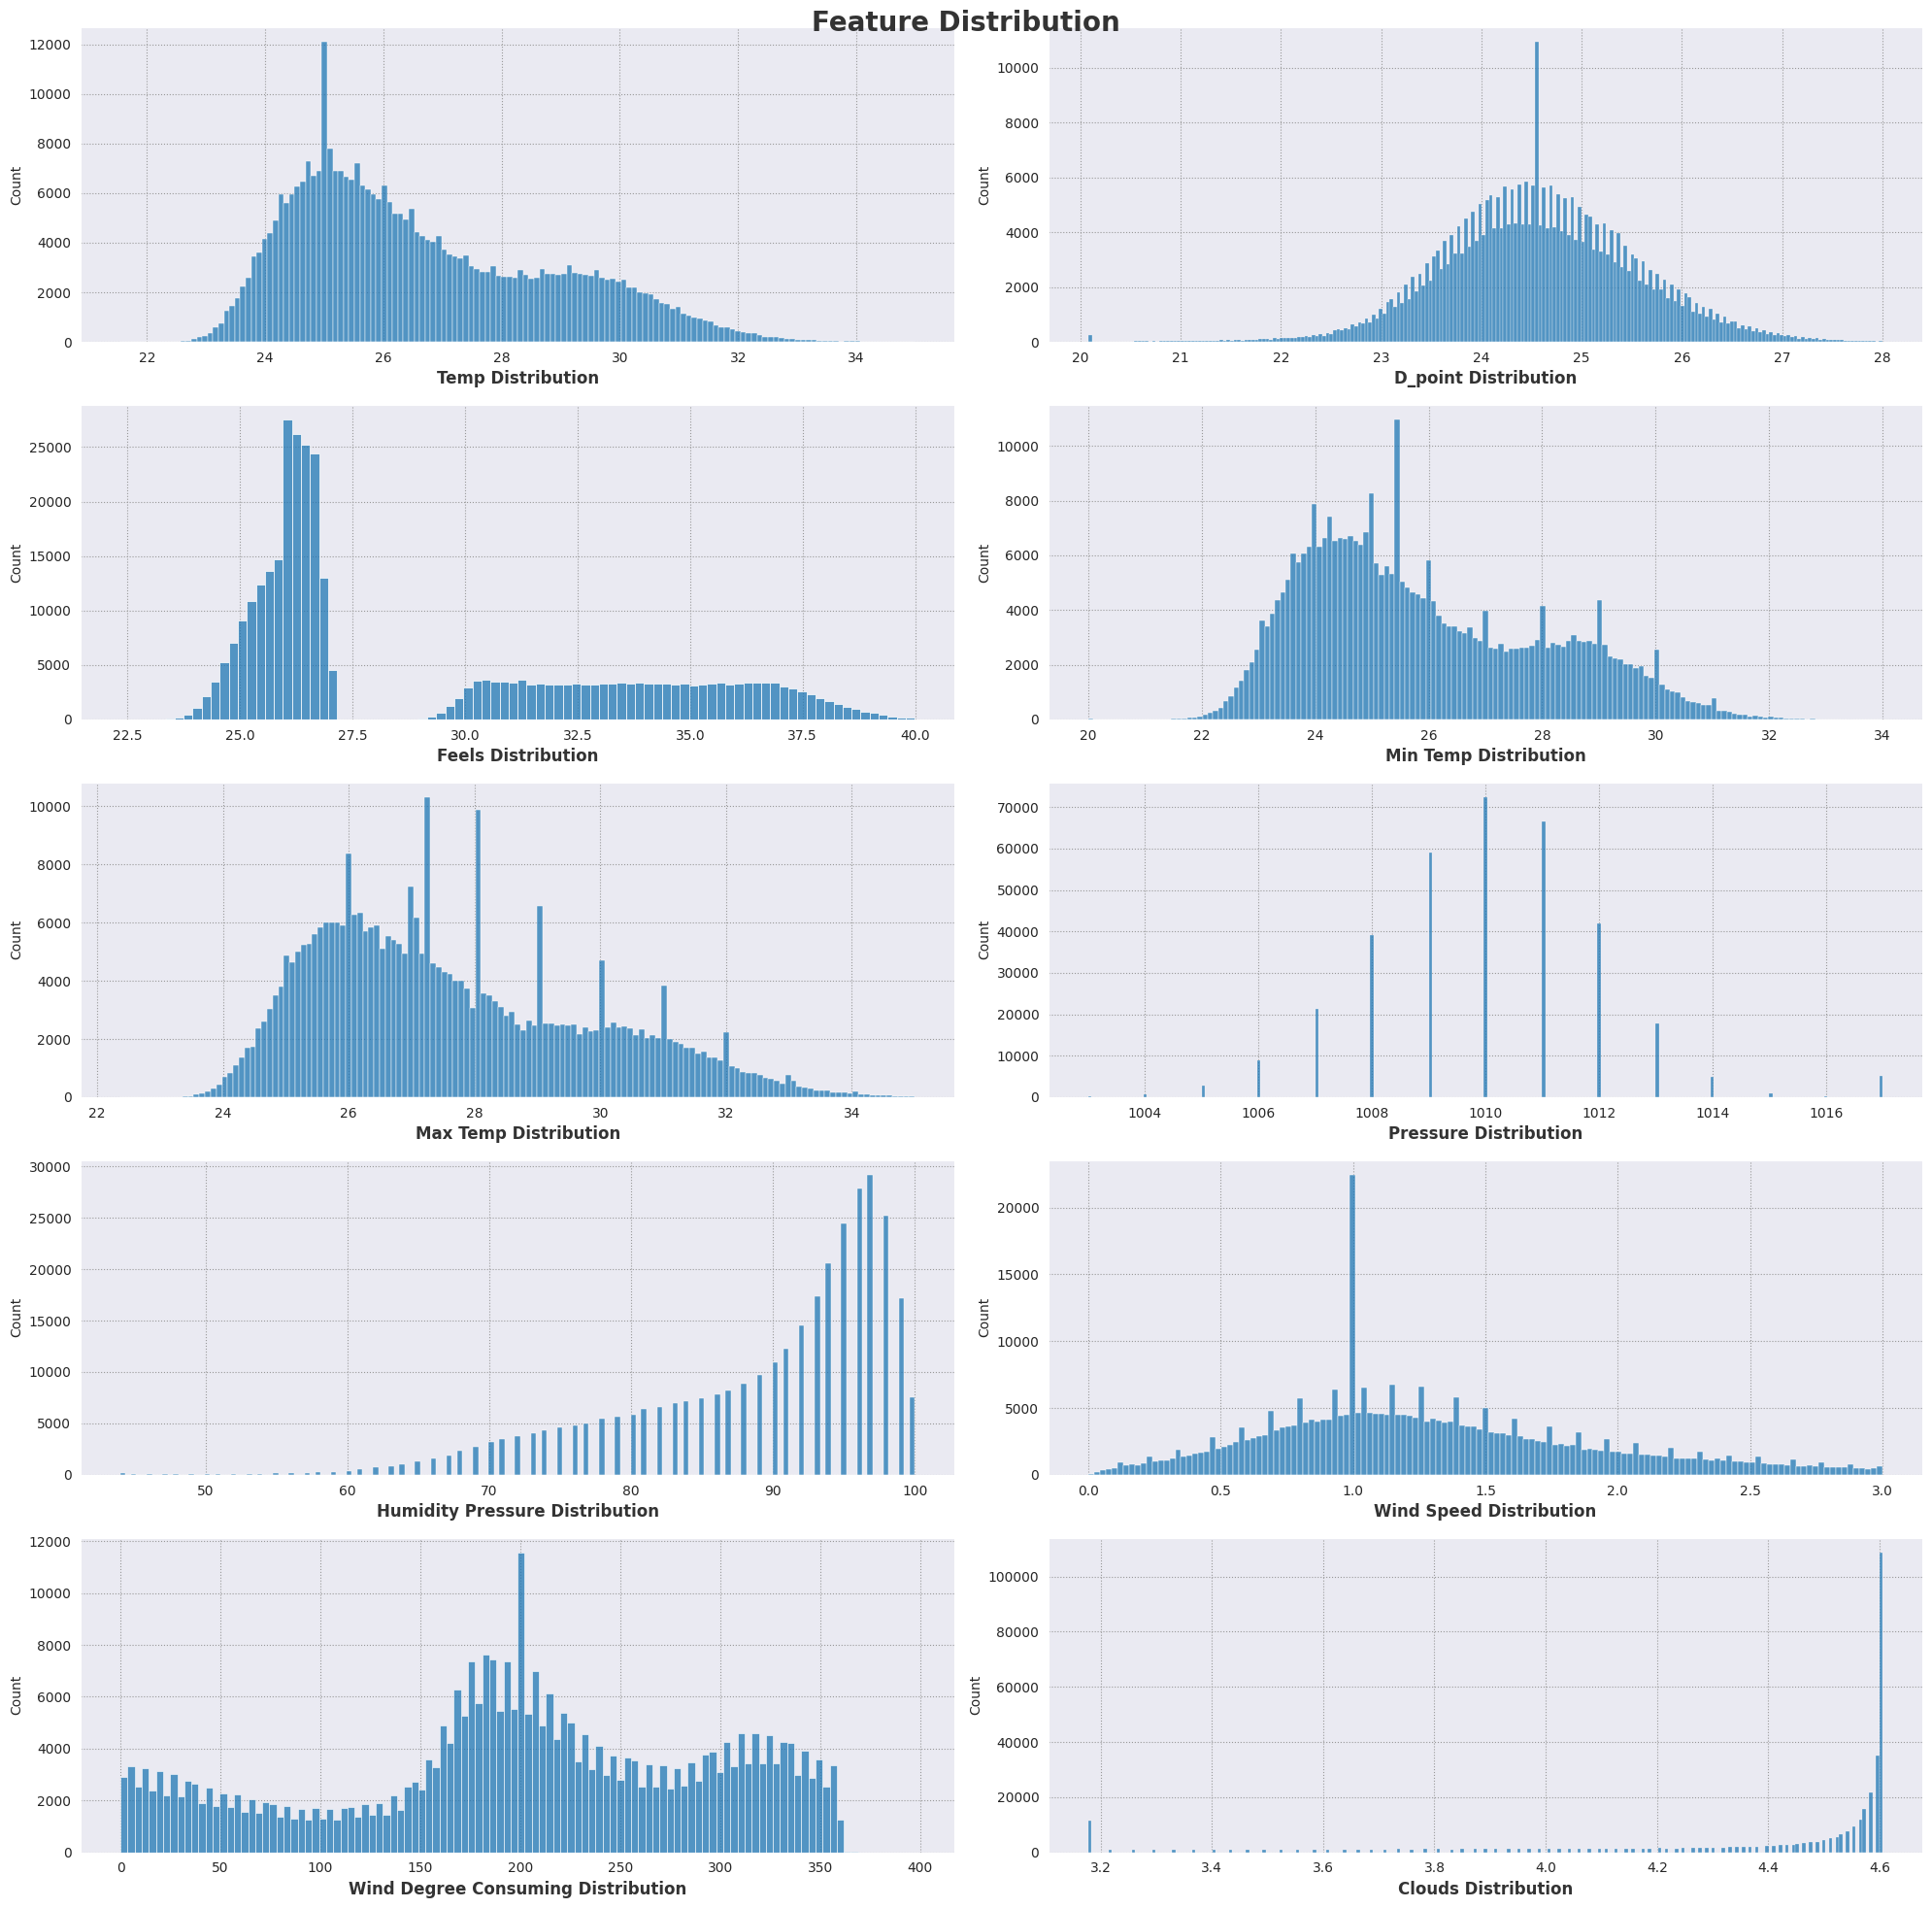

In [ ]:
plot_dist2(train_transformed)

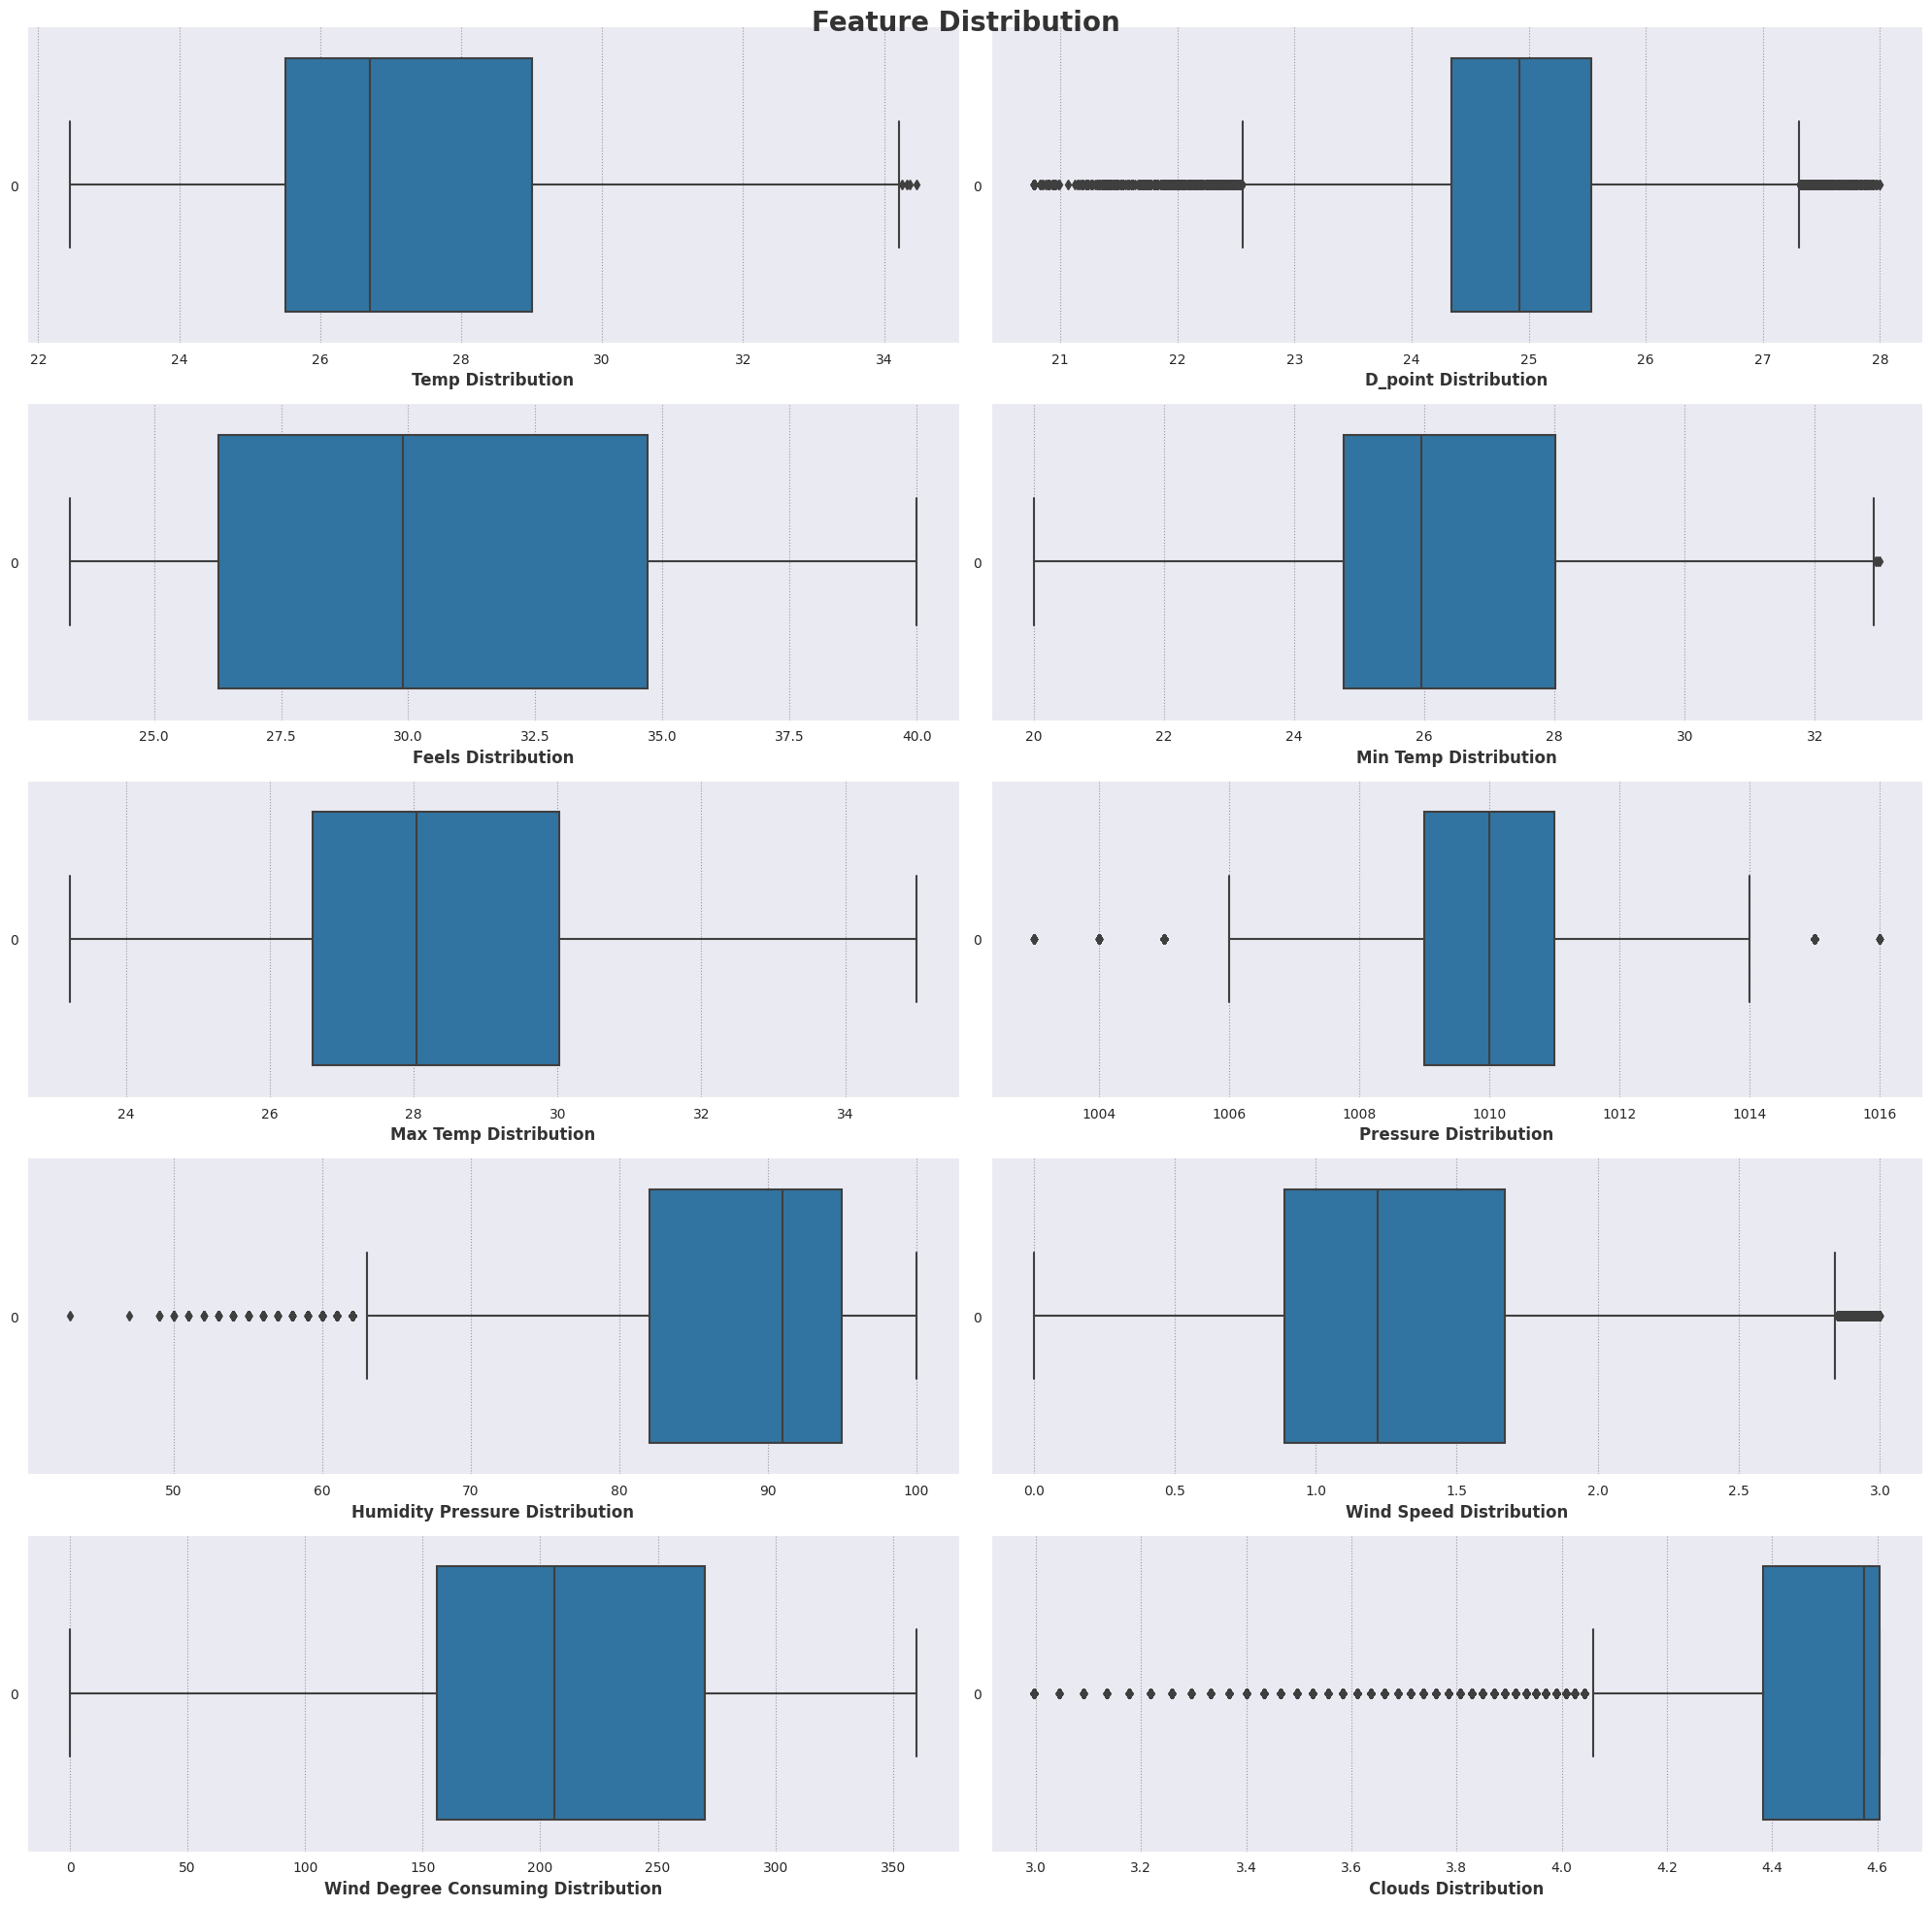

In [ ]:
# @title <p> Visualize Test Distribution
plot_dist(test_transformed)

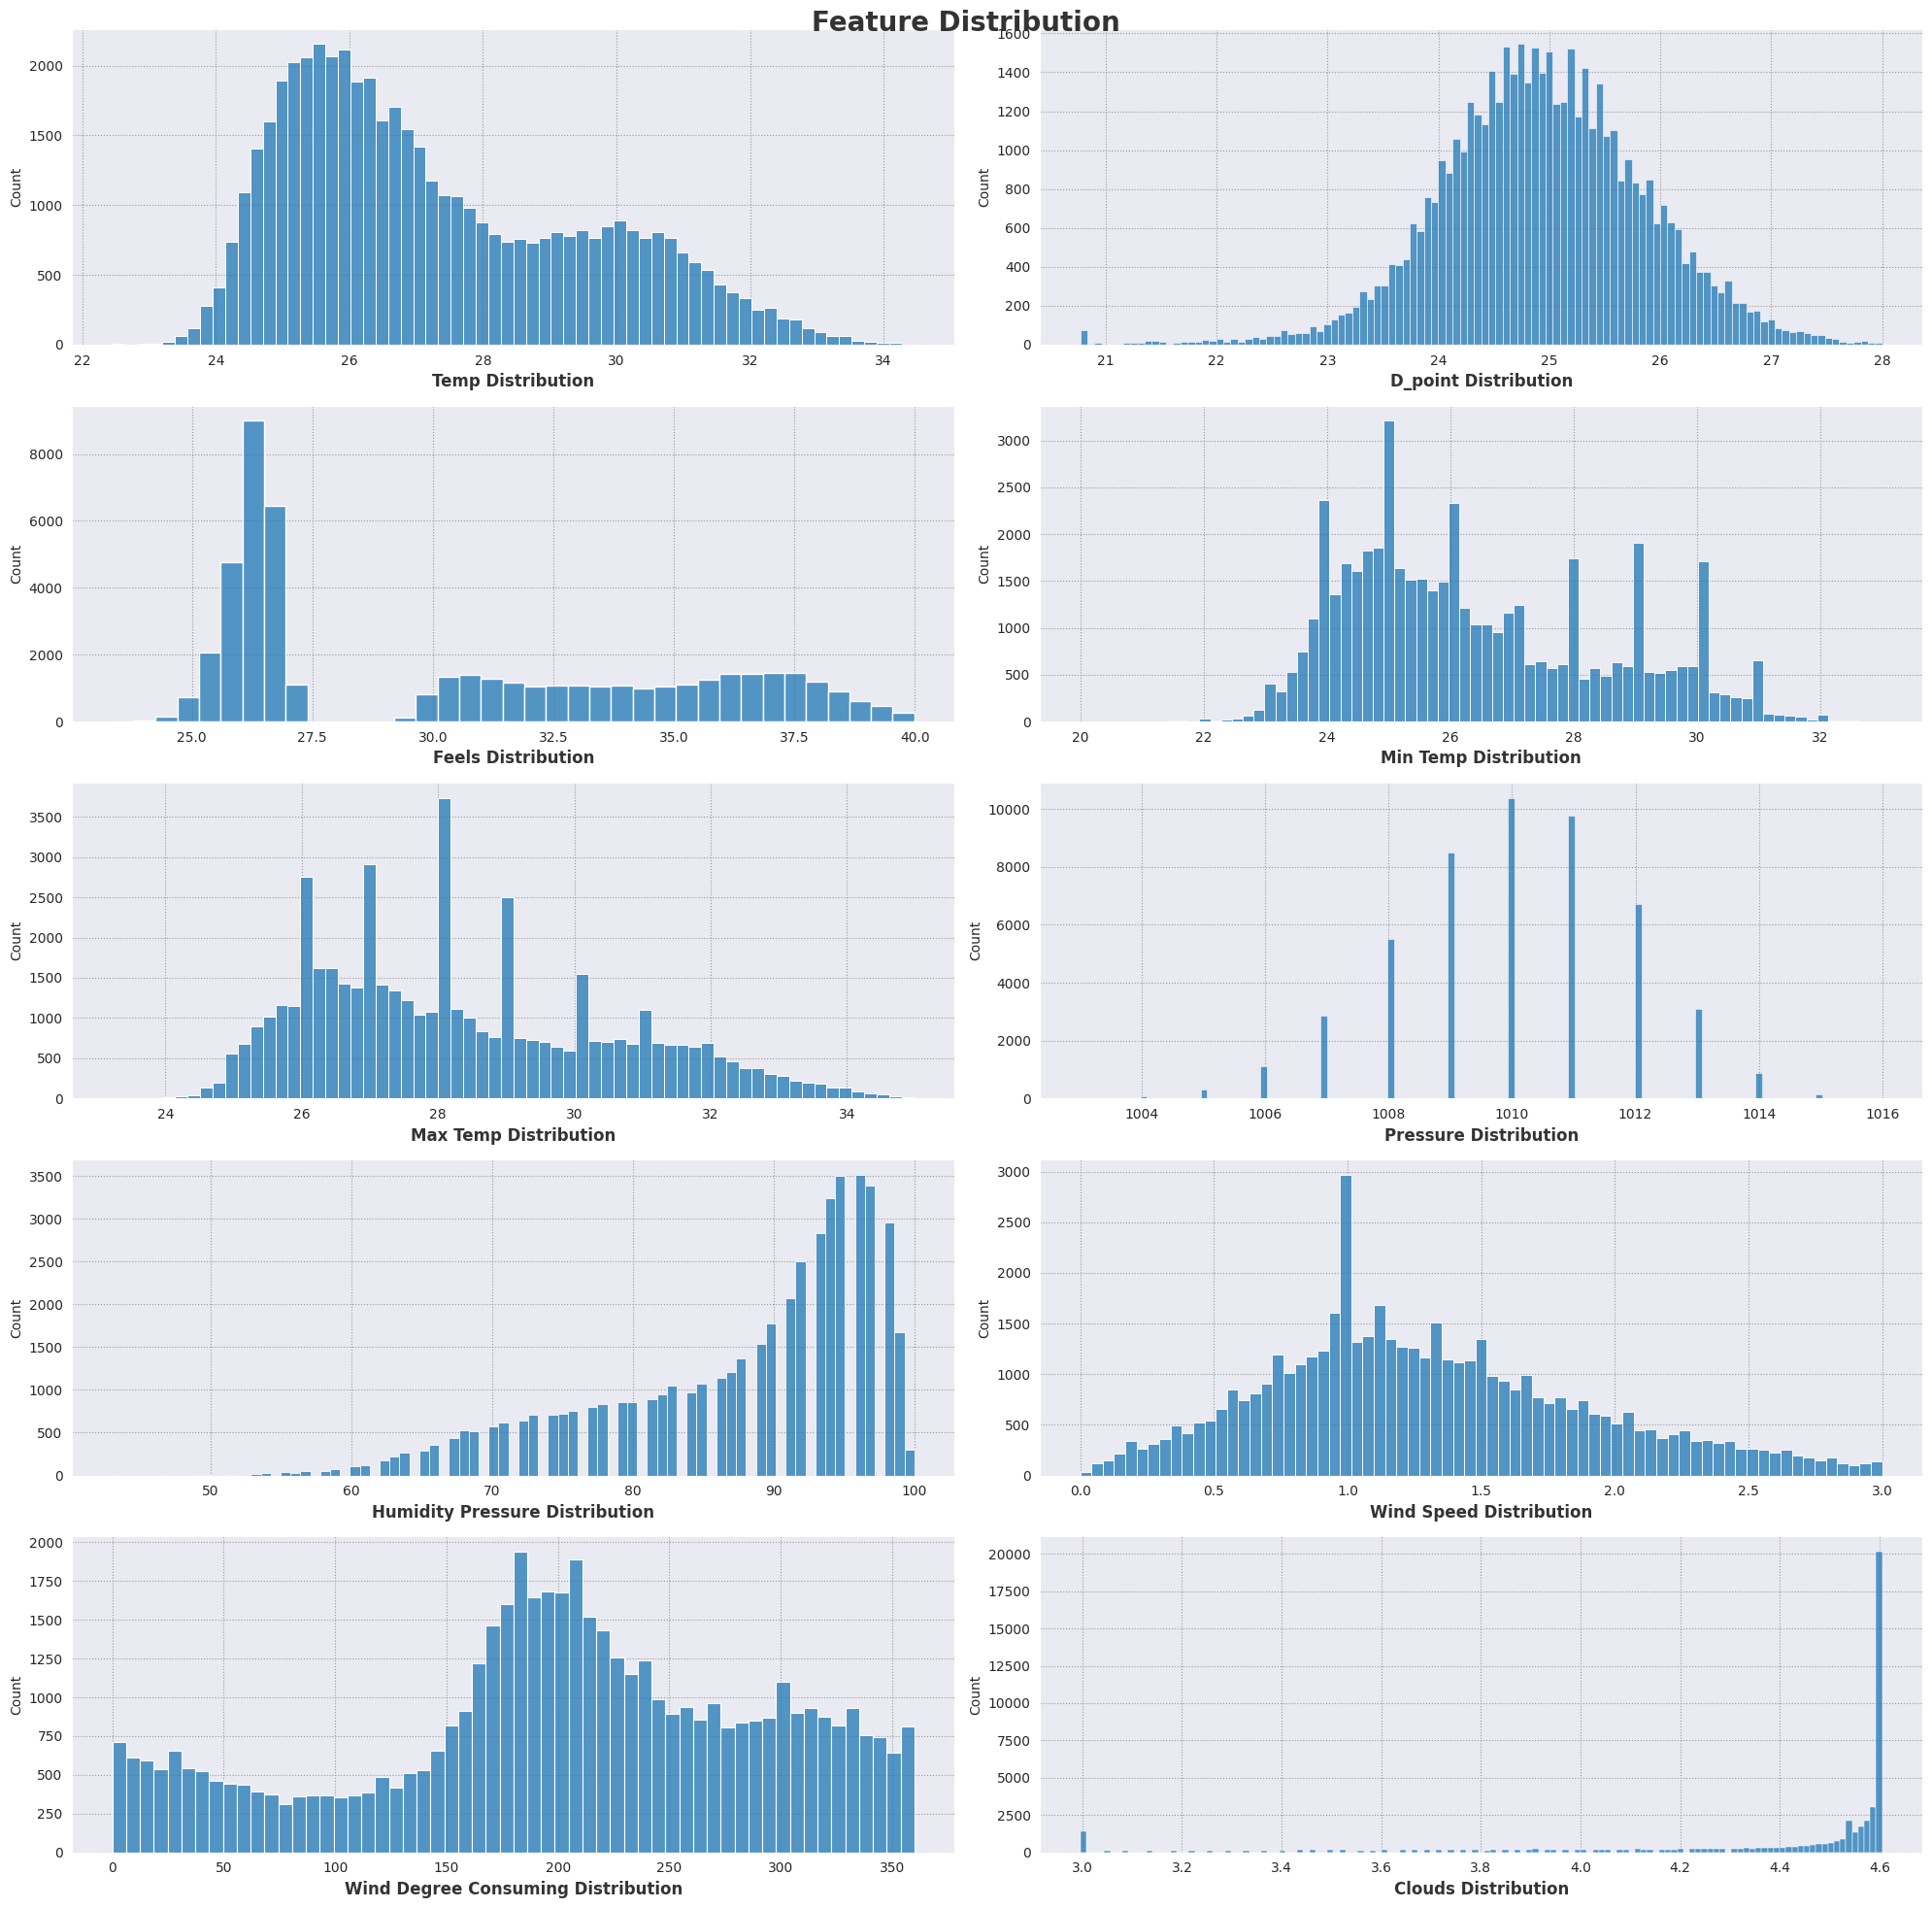

In [ ]:
plot_dist2(test_transformed)

## Modelling CatBoostRegressor

In [ ]:
# @title <p> Make a feature and label
zero_importance_features = [
    "grnd__-1", "grnd__unsettled", "grnd__not_recorded"
]

X = train_transformed.drop(['datetime_iso', 'rain_1h'], axis=1)
X.drop(columns=zero_importance_features, inplace=True)
y = train_transformed['rain_1h']

test_transformed.drop(columns=zero_importance_features, inplace=True)
X.shape, y.shape

((341880, 137), (341880,))


This code deletes features that have zero importance in the dataset. These features are identified in the `zero_importance_features` list. Next, these features are removed from both the training dataset (train_transformed) and the test dataset (test_transformed). This action helps optimize the model by focusing attention on features that have a significant contribution in predicting the target variable.

Then set the variable `X` as the modified training dataset by removing the 'datetime_iso' and 'rain_1h' columns. The column 'datetime_iso' was removed because it is not a predictor feature, while 'rain_1h' is the target variable to predict. The variable `y` is set as 'rain_1h', the target variable from which the predicted value will be taken. Using the `train_test_split` function from the scikit-learn module to split the training dataset (X, y) into a training dataset (X_train, y_train) and a validation dataset (X_test, y_test). This division is carried out with a proportion of 85% for training and 15% for validation (`test_size=.15`). `random_state=42` is used to ensure reproducibility of results when splitting data, so that the results can be the same if the code is rerun. This separation is important for training the model on the training dataset and testing its performance on the validation dataset before using it on new data.

In [ ]:
# @title <p> Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15, random_state=42)

The code below sets up a pipeline for data processing and modeling using CatBoostRegressor. The steps are as follows:
1. **StandardScaler**: Used to perform feature scaling by shifting the feature distribution so that it has a mean of 0 and a standard deviation of 1.
2. **Pipeline ("pipe")**: Arranges processing steps using a scaler.
3. **ColumnTransformer ("preprocessor")**: Applies processing steps (in this case, just scaling) to the appropriate columns in the dataset.
4. **Pipeline ("pipeline")**: Combines a preprocessor with an estimation model, in this case CatBoostRegressor, to form a complete pipeline for model training and evaluation.

In [ ]:
# @title <p> Make Pipeline
scaler = StandardScaler()
lr = 0.1
iterations=1000

pipe = Pipeline(
    steps=[
        ("scaler", scaler)])
preprocessor = ColumnTransformer([
        ("pipe", pipe, X_train.columns)])
pipeline = Pipeline([
        ("prep", preprocessor),
        ("estimator", CatBoostRegressor(iterations=iterations,
                                        learning_rate=lr,
                                         random_seed=1234
                                        # task_type="GPU",
                                        # devices='0:1'
                                        ))])

In [ ]:
# @title <p> Fit the model
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(f'RMSE : {math.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAE : {mean_absolute_error(y_test, y_pred)}')

0:	learn: 0.9101751	total: 99.4ms	remaining: 1m 39s
1:	learn: 0.8853531	total: 203ms	remaining: 1m 41s
2:	learn: 0.8656272	total: 310ms	remaining: 1m 42s
3:	learn: 0.8481897	total: 422ms	remaining: 1m 45s
4:	learn: 0.8342444	total: 543ms	remaining: 1m 48s
5:	learn: 0.8229185	total: 650ms	remaining: 1m 47s
6:	learn: 0.8133949	total: 764ms	remaining: 1m 48s
7:	learn: 0.8058034	total: 888ms	remaining: 1m 50s
8:	learn: 0.7990801	total: 994ms	remaining: 1m 49s
9:	learn: 0.7937742	total: 1.1s	remaining: 1m 49s
10:	learn: 0.7889382	total: 1.21s	remaining: 1m 48s
11:	learn: 0.7851293	total: 1.34s	remaining: 1m 50s
12:	learn: 0.7811015	total: 1.44s	remaining: 1m 49s
13:	learn: 0.7784994	total: 1.54s	remaining: 1m 48s
14:	learn: 0.7756089	total: 1.66s	remaining: 1m 49s
15:	learn: 0.7734027	total: 1.79s	remaining: 1m 50s
16:	learn: 0.7710167	total: 1.92s	remaining: 1m 50s
17:	learn: 0.7691412	total: 2.05s	remaining: 1m 51s
18:	learn: 0.7673933	total: 2.16s	remaining: 1m 51s
19:	learn: 0.7657125	t

This code trains the model by calling the `fit` method on a previously created pipeline. The model used is CatBoostRegressor which has been integrated in the pipeline. After training the model, predictions are made on the validation dataset (X_test) and the Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) are calculated to evaluate the model performance. RMSE and MAE are evaluation metrics commonly used to measure how well a model predicts data it has never seen. The smaller the RMSE and MAE values, the better the model's performance in making predictions.

## Hyperparameter Tuning

Using the Optuna library to perform hyperparameter optimization on the CatBoostRegressor model. The `objective` function defines the hyperparameters to be optimized (such as number of iterations, depth, learning rate, etc.), and then uses the hyperparameter values ​​proposed by Optuna to train the model with those parameters. The optimization goal is to find a combination of hyperparameters that produces the lowest Root Mean Squared Error (RMSE) value on the validation dataset. The Optuna study was carried out by running a number of trials that tried various combinations of hyperparameters to find the best one. The final result is a combination of hyperparameters that produces the lowest RMSE in the CatBoostRegressor model.

In [ ]:
# @title <p> Optuna Hyperparams Tuning
# def objective(trial):
#     params = {
#         'iterations': trial.suggest_int('iterations', 950, 1050),
#         'depth': trial.suggest_int('depth', 5, 7),
#         'learning_rate': trial.suggest_float('learning_rate', 0.0875, 0.125),
#         'bagging_temperature': trial.suggest_float('bagging_temperature', 2.5, 3.5),
#     }

#     pipeline = Pipeline([
#         ("prep", preprocessor),
#         ("estimator", CatBoostRegressor(**params))
#     ])

#     pipeline.fit(X_train, y_train)
#     y_pred = pipeline.predict(X_test)
#     rmse = math.sqrt(mean_squared_error(y_test, y_pred))

#     return rmse

# # Create a study object and specify the direction is 'minimize'.
# study = optuna.create_study(direction='minimize')

# # Optimize the study, the objective function is passed in as the first argument.
# study.optimize(objective, n_trials=100)


The code below displays a list of features along with their level of importance (importance) obtained from the model. The features are ordered in descending order of importance, making it possible to see the contribution of each feature to the model predictions. This information helps in understanding the features that have the most significant impact on predictions.

In [ ]:
# @title <p> Feature Importances
pd.DataFrame({
    'Features' : X_train.columns,
    'Importances' : pipeline['estimator'].feature_importances_}).sort_values('Importances', ascending=False)

NameError: ignored

## Submission

In [ ]:
# @title <p> Make a prediction on test data
X_submit = test_transformed.drop('datetime_iso', axis=1)
hasil = pipeline.predict(X_submit)

sub['rain_1h'] = hasil
sub['rain_1h'] = sub['rain_1h'].apply(lambda x : x if x >=0 else 0)
sub

,datetime_iso,rain_1h
0,2018-01-01 00:00:00+00:00,0.412193
1,2018-01-01 01:00:00+00:00,0.252362
2,2018-01-01 02:00:00+00:00,0.113828
3,2018-01-01 03:00:00+00:00,0.000000
4,2018-01-01 04:00:00+00:00,0.406485
...,...,...
49363,2023-08-19 19:00:00+00:00,0.103400
49364,2023-08-19 20:00:00+00:00,0.000000
49365,2023-08-19 21:00:00+00:00,0.000000
49366,2023-08-19 22:00:00+00:00,0.000000


In [ ]:
# @title <p> Save Checkpoint
save_config(submit=True, download=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# @title <p> Submit
!kaggle competitions submit -c tahap-penyisihan-oq-dataquestua -f '/content/submission/SUB_2023-09-23 12:59:13.993122/submission.csv' -m 'Timo, 23/09'

100% 2.06M/2.06M [00:00<00:00, 3.76MB/s]
Successfully submitted to Tahap Penyisihan Objective Quest - DATAQUEST